In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from tqdm import tqdm
import os
import data_utils
import model_utils
from model_utils import train_torch_model, test_torch_model, port_mlp_to_ch, port_ch_to_mlp, proxy_train_mlp, get_CSMIA_case_by_case_results, CSMIA_attack
from data_utils import oneHotCatVars, filter_random_data_by_conf_score
from whitebox_attack import neuron_output, make_neuron_output_data, roc_curve_plot, get_LOMIA_case_1_correct_examples, Top10CorrNeurons, wb_corr_attacks
from disparate_vulnerability_utils import get_accuracy, get_indices_by_conditions, subgroup_vulnerability_distance_vector, subgroup_vulnerability_distance, get_subgroup_disparity, plot_subgroup_disparity, improved_subgroup_attack, get_subgroup_disparity_baseline, get_top_dist_indices, get_disparity_by_subgroup
import shap
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network._base import ACTIVATIONS
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
import pickle
# import utils
import copy

import matplotlib as mpl

# Setting the font family, size, and weight globally
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.weight'] = 'light'

In [4]:
class MIAExperiment:
    def __init__(self, *args, **kwargs):
        self.sampling_condition_dict_list = kwargs.get('sampling_condition_dict_list', None)
        self.sensitive_column = kwargs.get('sensitive_column', 'MAR')

        for key, value in kwargs.items():
            setattr(self, key, value)

        if not hasattr(self, 'name'):
            self.name = 'Census19'
        self.ds = data_utils.CensusWrapper(
                    filter_prop="none", ratio=float(0.5), split="all", name=self.name, sampling_condition_dict_list=self.sampling_condition_dict_list, sensitive_column=self.sensitive_column,
                    additional_meta=None)
        (self.x_tr, self.y_tr), (self.x_te, self.y_te), self.cols = self.ds.load_data()
        self.X_train = pd.DataFrame(self.x_tr, columns=self.cols)
        self.X_test = pd.DataFrame(self.x_te, columns=self.cols)
        self.y_tr_onehot = self.ds.ds.y_enc.transform(self.y_tr).toarray()
        self.y_te_onehot = self.ds.ds.y_enc.transform(self.y_te).toarray()

    def __str__(self):
        return self.ds.ds.filenameroot
    
    def __repr__(self):
        return self.ds.ds.filenameroot
    
    def get_value_count_report(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # print(df[df[self.subgroup_column] == value].columns)
            # print(df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]])
            new_df = df[df[self.subgroup_column] == value][[self.sensitive_column, self.y_column]]
            print(new_df.value_counts())
            # print(df[df[self.subgroup_column == value]][[self.sensitive_column, self.y_column]].corr())


    def get_mutual_information_between_sens_and_y(self):
        df = self.ds.ds.original_df
        df = df[df['is_train'] == 1]
        subgroup_values = df[self.subgroup_column].unique().tolist()
        mutual_info_dict = {}
        for value in subgroup_values:
            print(f"Subgroup: {value}")
            # All the features except y column
            X = df[df[self.subgroup_column] == value].drop([self.y_column], axis=1)
            y = df[df[self.subgroup_column] == value][[self.y_column]]
            # print(mutual_info_classif(X, y, discrete_features=True))
            mutual_info_dict[value] = mutual_info_classif(X, y, discrete_features=True)
        return mutual_info_dict

In [5]:
experiments = { f"corr_btn_sens_and_out_{(i, j)}":  MIAExperiment(sampling_condition_dict_list = 
    {
            'correlation': 0,
            'subgroup_col_name': 'SEX',
            'marginal_prior': 1,
            'corr_btn_sens_and_output_per_subgroup': (i, j),
            # 'fixed_corr_in_test_data': True
    }, shortname = f"Corr_btn_sens_and_output_for_male_({i})_for_female_({j})"
) for (i, j) in [(k, k) for k in [-0.4, -0.35, -0.3, -0.25, -0.2][:1]]}
# ) for i in [-0.4, -0.3, -0.2, -0.1, 0][:1] for j in [-0.4, -0.3, -0.2, -0.1, 0][3:4]}

num_of_sample_tuples: [(8750, 6875), (3750, 5625), (3750, 5625), (8750, 6875), (8750, 7500), (3750, 5000), (3750, 5000), (8750, 7500)]
scale_down_factor: 1.2727272727272727
{0: {(0, 1): 6875, (0, 0): 2946, (1, 1): 2946, (1, 0): 6875}, 1: {(0, 1): 6875, (0, 0): 2946, (1, 1): 2946, (1, 0): 6875}}


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


{0: {(0, 1): 6875, (0, 0): 5625, (1, 1): 5625, (1, 0): 6875}, 1: {(0, 1): 7500, (0, 0): 5000, (1, 1): 5000, (1, 0): 7500}}


100%|██████████| 2/2 [00:00<00:00, 1163.47it/s]


In [6]:
save_model = True

for experiment_key in experiments:
    experiment = experiments[experiment_key]
    print(f"Training classifier for experiment: {experiment}")
    try:
        experiment.clf_only_on_test = model_utils.load_model(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')
        print(f"Loaded classifier for experiment from file: {experiment}")
    except:
        # clf = model_utils.get_model(max_iter=500, hidden_layer_sizes=(256, 256))
        experiment.clf_only_on_test = copy.deepcopy(base_model)
        experiment.clf_only_on_test.fit(experiment.X_test, experiment.y_te_onehot)

        if save_model:
            model_utils.save_model(experiment.clf_only_on_test, f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_target_model_only_on_test_dummy.pkl')

Training classifier for experiment: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN
Loaded classifier for experiment from file: Census19_correlation_0_subgroup_col_name_SEX_marginal_prior_1_corr_btn_sens_and_output_per_subgroup_LPAREN-0.4, -0.4RPAREN


In [7]:
experiment = experiments['corr_btn_sens_and_out_(-0.4, -0.4)']
X_random_df, X_random_oh_df = filter_random_data_by_conf_score(experiment.ds, experiment.clf_only_on_test, condition=[])

In [8]:
experiment.X_random_df = X_random_df
experiment.X_random = X_random_oh_df.drop(columns=experiment.ds.ds.meta['y_column'])
experiment.y_random = np.expand_dims(X_random_oh_df[experiment.ds.ds.meta['y_column']].to_numpy(), 1)
experiment.y_random_onehot = experiment.ds.ds.y_enc.transform(experiment.y_random).toarray()

In [9]:
test_df = experiment.ds.ds.original_df[experiment.ds.ds.original_df['is_train'] == 0]
test_df = test_df.drop(['is_train'], axis=1)

test_df = test_df.drop([experiment.sensitive_column], axis=1)

test_np = test_df.to_numpy()[:50000, :]
test_np = test_np.astype(np.float32)

random_np = experiment.X_random_df.drop([experiment.sensitive_column], axis=1).to_numpy()[:50000, :]
random_np = random_np.astype(np.float32)

temp_np_1 = np.expand_dims(test_np, 0)
temp_np_2 = np.expand_dims(random_np, 1)

In [10]:
experiment.dist_matrix = np.count_nonzero(temp_np_1 - temp_np_2, axis=2)

In [11]:
np.save(f'<PATH_TO_MODEL>/{experiment.ds.ds.filenameroot}_dist_matrix_wout_sens_col_on_synthetic.npy', experiment.dist_matrix)

In [12]:
sens_pred, case_indices = CSMIA_attack(experiment.clf_only_on_test, experiment.X_test, experiment.y_te, experiment.ds.ds.meta)
correct_indices = (sens_pred == experiment.X_test[[f'{experiment.ds.ds.meta["sensitive_column"]}_1']].to_numpy().ravel())
incorrect_indices = ~correct_indices
case_2_correct_indices = np.where(np.logical_and(case_indices[2], correct_indices))[0]
case_2_incorrect_indices = np.where(np.logical_and(case_indices[2], incorrect_indices))[0]

In [28]:
def get_corr_btn_sens_and_out_for_indices(X, y, indices):
    X_new = X.loc[indices]
    y_new = y[indices]
    X_new = X_new[['MAR_1']].to_numpy().ravel()
    y_new = y_new.ravel()
    return np.corrcoef(X_new, y_new)[0, 1]

def get_percentage_of_same_sens_val_among_dist_k_neighbours(X, y, X_random, y_random, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    X_temp = X_random.iloc[dist_2_neighbours]
    orig_y = y[index]
    # print(orig_y)
    # print(X_temp[experiment.ds.ds.meta["y_column"]].to_numpy().ravel())
    dist_2_neighbours_y_values = X_temp[experiment.ds.ds.meta["y_column"]].to_numpy().ravel().astype(np.float)
    # print(dist_2_neighbours_y_values)
    dist_2_neighbours_w_same_y_indices = (orig_y == dist_2_neighbours_y_values)
    orig_sens_val = X.iloc[index][f'{experiment.ds.ds.meta["sensitive_column"]}_1']
    return (X_temp.iloc[dist_2_neighbours_w_same_y_indices][f'{experiment.ds.ds.meta["sensitive_column"]}'] == orig_sens_val).mean()

def get_percentage_of_neighbors_with_dominant_sens_val_pred_by_CSMIA_among_dist_k_neighbours(X, y, sens_pred, case_indices, index, k=3):
    dist_2_neighbours = experiment.dist_matrix[index] <= k
    dominant_sens_val = np.sum(sens_pred[dist_2_neighbours] == 1) > np.sum(sens_pred[dist_2_neighbours] == 0)
    return np.mean(sens_pred[dist_2_neighbours] == dominant_sens_val)

def get_corr_btn_sens_and_out_among_dist_k_neighbours(X, y, dist_matrix, index, k=3):
    dist_2_neighbours = dist_matrix[index] <= k
    try:
        return get_corr_btn_sens_and_out_for_indices(X, y, dist_2_neighbours)
    except:
        return np.nan

In [16]:
experiment.dist_matrix = experiment.dist_matrix.T

In [27]:
index = case_2_incorrect_indices[0]
get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random_df, experiment.y_random, experiment.dist_matrix, index, 10)

[0]
['0' '0' '0' ... '0' '0' '0']
[0. 0. 0. ... 0. 0. 0.]


1.0

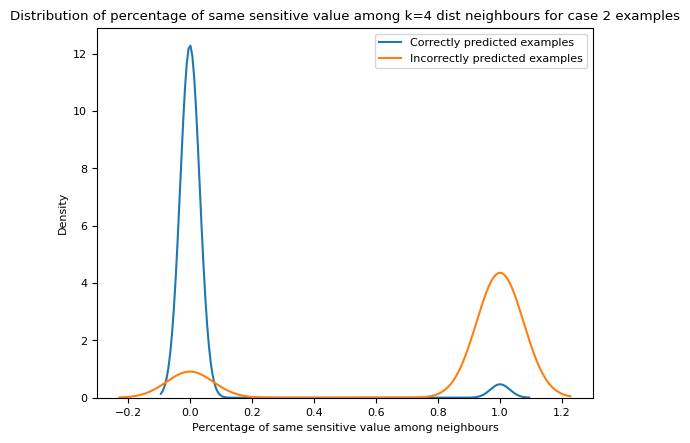

In [37]:
# compare the percentage of same sensitive value among k neighbours for correct and incorrect examples of case 2
k = 4
perc_same_sens_val_correct = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random_df, experiment.y_random, experiment.dist_matrix, index, k) for index in case_2_correct_indices])
perc_same_sens_val_incorrect = np.array([get_percentage_of_same_sens_val_among_dist_k_neighbours(experiment.X_test, experiment.y_te, experiment.X_random_df, experiment.y_random, experiment.dist_matrix, index, k) for index in case_2_incorrect_indices])

sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among randomly generated neighbours')
plt.ylabel('Density')
plt.title(f'Distribution of percentage of same sensitive value among k={k} dist neighbours for case 2 examples')
plt.legend()
plt.show()

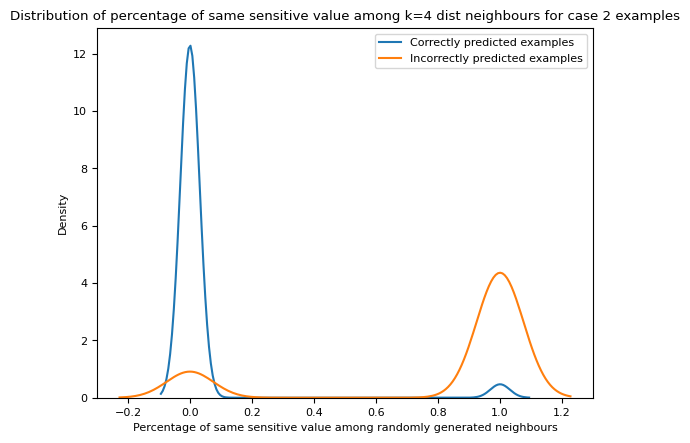

In [40]:
sns.kdeplot(perc_same_sens_val_correct, label='Correctly predicted examples')
sns.kdeplot(perc_same_sens_val_incorrect, label='Incorrectly predicted examples')
plt.xlabel('Percentage of same sensitive value among randomly generated neighbours')
plt.ylabel('Density')
plt.title(f'Distribution of percentage of same sensitive value among k={k} dist neighbours for case 2 examples')
plt.legend()
plt.show()

In [41]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_correct, nan=-1))

Counter({1.0: 292, -1.0: 11268, 0.0: 7649})

In [42]:
from collections import Counter
Counter(np.nan_to_num(perc_same_sens_val_incorrect, nan=-1))

Counter({1.0: 2580, -1.0: 5030, 0.0: 539})